In [106]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import string
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_colwidth',100)

In [2]:
df = pd.read_csv('tweet_product_company.csv', encoding='latin-1')
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upg...   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...   
2                      @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                   @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.shape #9093 rows and 3 columns

(9093, 3)

In [5]:
df.emotion_in_tweet_is_directed_at.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [6]:
df.is_there_an_emotion_directed_at_a_brand_or_product.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

## Data Preprocessing

In [7]:
df.rename(columns={'tweet_text':'tweet', 
                   'emotion_in_tweet_is_directed_at':'device',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

In [8]:
df.duplicated().sum()

22

In [9]:
df.drop_duplicates(keep='last', inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.isnull().values.any()

True

In [12]:
percentage_missing = round(df.isnull().sum() * 100 / len(df),4)
missing_value_df = pd.DataFrame({'Missing_Percentage' : percentage_missing})
missing_value_df.sort_values(by='Missing_Percentage', ascending = False).head()

Missing_Percentage
device              63.8188
tweet                0.0110
emotion              0.0000

In [13]:
df.drop(['device'], axis=1, inplace=True)

In [14]:
df.dropna(subset=['tweet'], inplace=True)

In [15]:
df.isnull().values.any()

False

## Exploratory Data Analysis (EDA) - Feature Engineering

In [16]:
df.head()

tweet  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upg...   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...   
2                      @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                   @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4  @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

## Feature Engineering - 'emotion' Feature

In [17]:
df.emotion.value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

In [18]:
to_drop_row = ["I can't tell"]
df = df[df.emotion.isin(to_drop_row) == False]

In [19]:
df.emotion.value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: count, dtype: int64

In [20]:
df['emotion'] = np.where(df['emotion'].str.contains('No emotion toward brand or product'), 
                         'Neutral emotion', df['emotion'])

In [21]:
df.emotion.value_counts()

emotion
Neutral emotion     5375
Positive emotion    2970
Negative emotion     569
Name: count, dtype: int64

## SXSW in Tweet Analysis

In [22]:
df_sxsw = df[df['tweet'].str.contains('sxsw')]
df_sxsw.head()

tweet  \
3                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
8   Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad ap...   
10  Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still runnin...   
14                                    Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
15                   haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw   

             emotion  
3   Negative emotion  
8   Positive emotion  
10  Positive emotion  
14  Positive emotion  
15  Positive emotion

In [23]:
df_sxsw.shape #4596 rows are related with sxsw

(4596, 2)

In [24]:
emotion = df_sxsw['emotion'].value_counts()
transuction = emotion.index
quantity = emotion.values

# draw pie circule with plotly
figure = px.pie(df,
               values = quantity,
               names = transuction,
               hole = .5,
               title = 'Emotion distribution of the tweets contains #SXSW')
figure.show()

## Hashtag Analysis for SXSW

In [25]:
def hashtag_extract(x):
    hashtags =[]
    
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [26]:
df_sxsw['tweet'][df_sxsw['emotion'] == 'Positive emotion']

8       Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad ap...
10      Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still runnin...
14                                        Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l
15                       haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw
22                       Okay, this is really it: yay new @Foursquare for #Android app!!!!11 kthxbai. #sxsw
                                                       ...                                                 
9060    @mention you might also appreciate new iPhone app tweetcaster. Zip it feature let's you hide ANY...
9061    @mention You realize I'm still padless? I just gave away a case at #bmm with @mention - need to ...
9070     You know you've made it to #sxsw when you see a bunch of grown men hooting over getting the iPad 2
9072    @mention your iPhone

In [27]:
HT_positive = hashtag_extract(df_sxsw['tweet'][df_sxsw['emotion'] == 'Positive emotion'])
HT_negative = hashtag_extract(df_sxsw['tweet'][df_sxsw['emotion'] == 'Negative emotion'])
HT_neutral = hashtag_extract(df_sxsw['tweet'][df_sxsw['emotion'] == 'Neutral emotion'])

In [28]:
HT_positive = sum(HT_positive, [])
HT_negative = sum(HT_negative, [])
HT_neutral = sum(HT_neutral, [])

### Positive Hashtags Analysis

In [29]:
nltk.FreqDist(HT_positive)

FreqDist({'sxsw': 1486, 'SXSW': 57, 'sxswi': 53, 'apple': 52, 'ipad2': 34, 'google': 32, 'iPad': 25, 'hollergram': 20, 'android': 19, 'tapworthy': 19, ...})

In [30]:
a = nltk.FreqDist(HT_positive)
b = pd.DataFrame({'Hashtag':list(a.keys()), 
                  'Count':list(a.values())})
b.head()

Hashtag  Count
0  hollergram     20
1        sxsw   1486
2        fail      2
3     Android      8
4      austin     10

In [31]:
b = b.nlargest(columns='Count', n=10)
b.head(10)

Hashtag  Count
1         sxsw   1486
14        SXSW     57
13       sxswi     53
36       apple     52
6        ipad2     34
30      google     32
24        iPad     25
0   hollergram     20
5      android     19
50   tapworthy     19

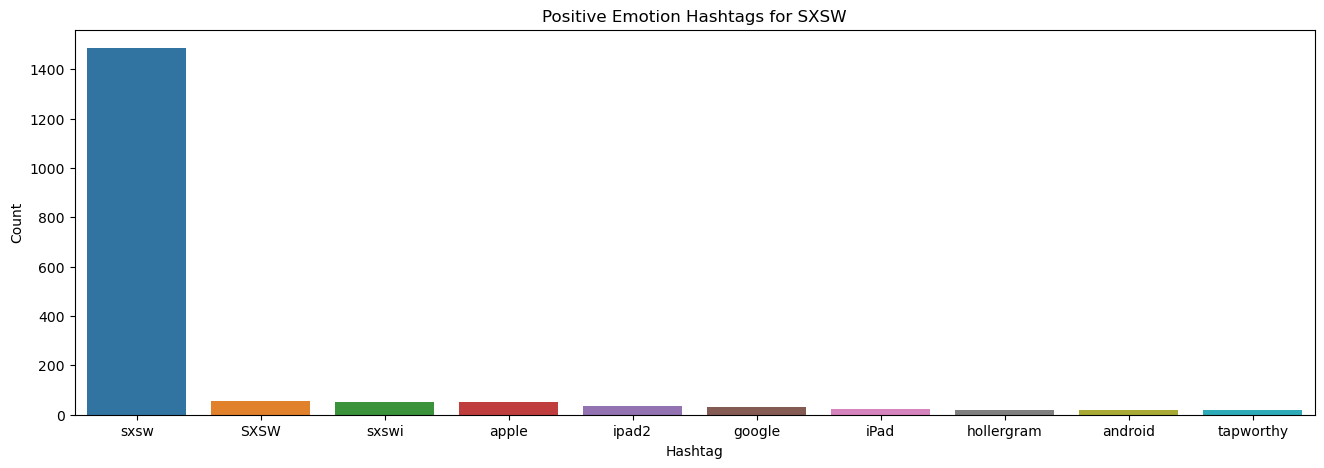

In [32]:
plt.figure(figsize=(16,5))
sns.barplot(data=b, x='Hashtag', y='Count')
plt.title('Positive Emotion Hashtags for SXSW')
plt.show()

### Negative Hashtags Analysis

In [33]:
a = nltk.FreqDist(HT_negative)
b = pd.DataFrame({'Hashtag':list(a.keys()), 
                  'Count':list(a.values())})
b = b.nlargest(columns='Count', n=10)

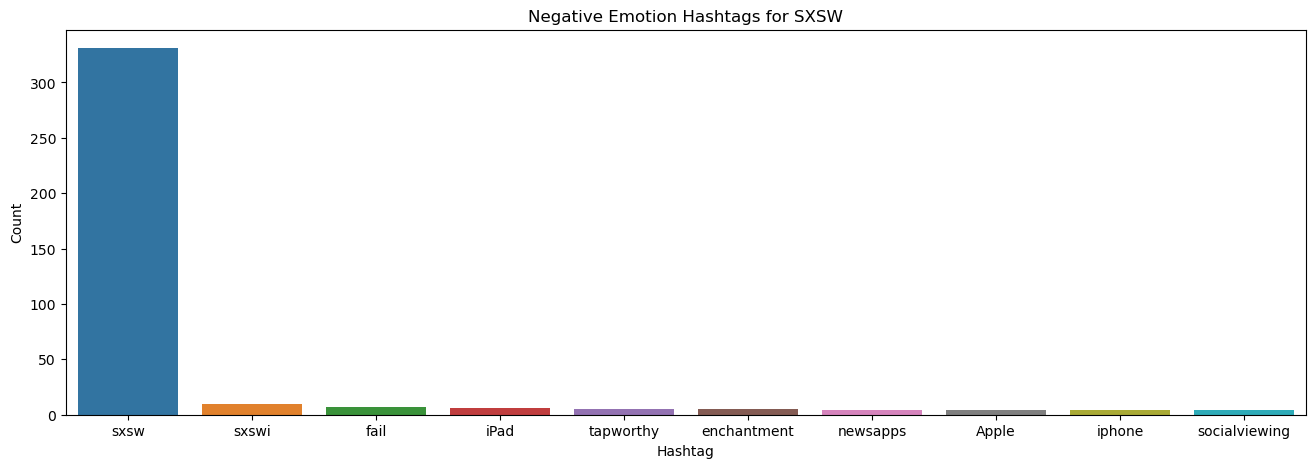

In [34]:
plt.figure(figsize=(16,5))
sns.barplot(data=b, x='Hashtag', y='Count')
plt.title('Negative Emotion Hashtags for SXSW')
plt.show()

### Neutral Hashtags Analysis

In [35]:
a = nltk.FreqDist(HT_neutral)
b = pd.DataFrame({'Hashtag':list(a.keys()), 
                  'Count':list(a.values())})
b = b.nlargest(columns='Count', n=10)

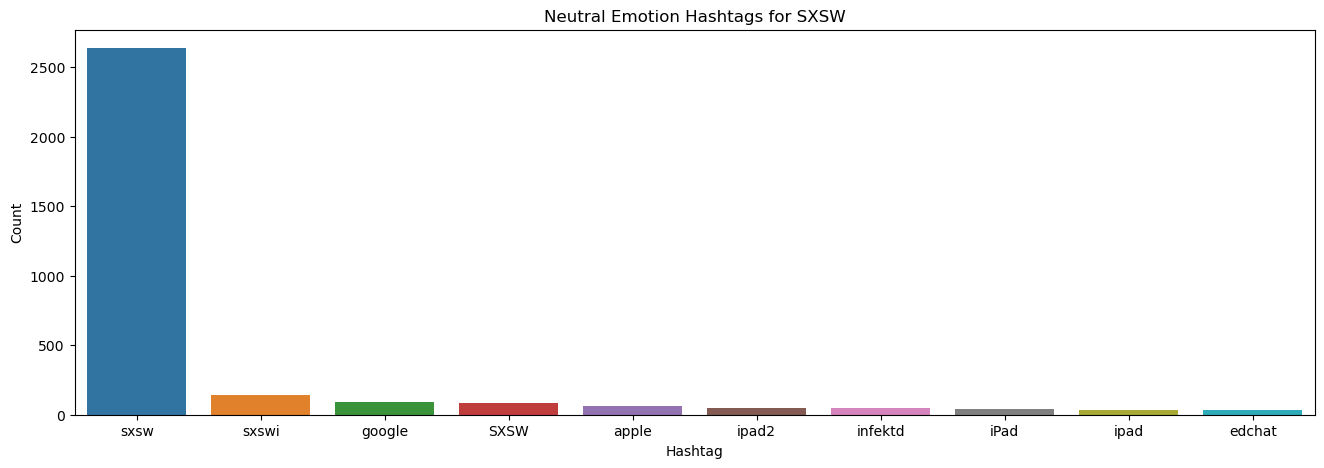

In [36]:
plt.figure(figsize=(16,5))
sns.barplot(data=b, x='Hashtag', y='Count')
plt.title('Neutral Emotion Hashtags for SXSW')
plt.show()

## Feature Engineering of 'Tweet' Feature
* re.sub(pattern, repl, string, count=0, flags=0)
* The small letter “s” metacharacter stands for space, and the capital letter “S” stands for non-space.

In [37]:
df_sxsw.head()

tweet  \
3                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
8   Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad ap...   
10  Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still runnin...   
14                                    Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
15                   haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw   

             emotion  
3   Negative emotion  
8   Positive emotion  
10  Positive emotion  
14  Positive emotion  
15  Positive emotion

In [38]:
def cleanTweets(tweets):
    twt = tweets.lower() #convert all letters to lower case
    twt = re.sub("@[A-Za-z0-9_]+","", twt) #remove mentions
    twt = re.sub(r"http\S+", "", twt) #remove url's https tags
    twt = re.sub(r"www.\S+", "", twt) #remove url's www tags
    twt = re.sub("[^a-z0-9]"," ", twt) #remove non-alphanumeric characters
    twt = re.sub('[\s]+', ' ', twt) #Remove additional white spaces
    twt = re.sub(r"sxsw", "", twt) #Remove sxsw from tweets
    return twt

In [39]:
cleantext = []

for item in df_sxsw['tweet']:
    twt = cleanTweets(item)
    cleantext += [twt]

df_sxsw['clean_tweets'] = cleantext
df_sxsw.head(10)

tweet  \
3                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
8   Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad ap...   
10  Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still runnin...   
14                                    Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
15                   haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw   
16         Holler Gram for iPad on the iTunes App Store -  http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw   
22                   Okay, this is really it: yay new @Foursquare for #Android app!!!!11 kthxbai. #sxsw   
26  RT haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw (via @mich...   
27                 someone started an #austin @PartnerHub group in google groups, pre-#sxsw. great idea   
29       They were right, the @gowalla 3 app on #android is sweeeeet! Nice job by the team there. #sxsw   

             emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   
16   Neutral emotion   
22  Positive emotion   
26  Positive emotion   
27  Positive emotion   
29  Positive emotion   

                                                                                    clean_tweets  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from   
15                                                    haha awesomely rad ipad app by hollergram   
16                                             holler gram for ipad on the itunes app store via   
22                                    okay this is really it yay new for android app 11 kthxbai   
26                                            rt haha awesomely rad ipad app by hollergram  via   
27                              someone started an austin group in google groups pre  great idea  
29                  they were right the 3 app on android is sweeeeet nice job by the team there

In [40]:
df_sxsw = df_sxsw.drop(['tweet'],axis=1)
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                                                    clean_tweets  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from   
15                                                    haha awesomely rad ipad app by hollergram

## WordClouds

In [41]:
def create_wordclouds(tweet,emotion):
    texts=[]
    
    for x in df_sxsw[df_sxsw['emotion']==emotion]['clean_tweets'].str.split():
        for i in x:
            texts.append(i)
    return texts

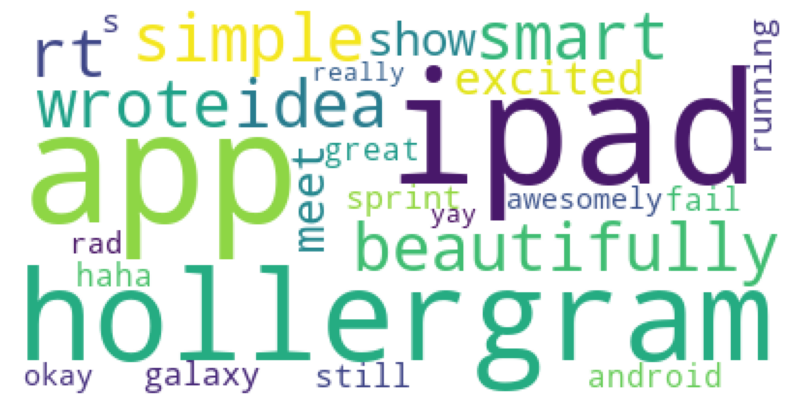

In [42]:
wordcloud_positive = create_wordclouds(df_sxsw,'Positive emotion')
word_cloud_pos = WordCloud(background_color='white',max_font_size=80).generate(" ".join(wordcloud_positive[:50]))
plt.figure(figsize=(10,6))
plt.imshow(word_cloud_pos)
plt.axis('off')
plt.show()

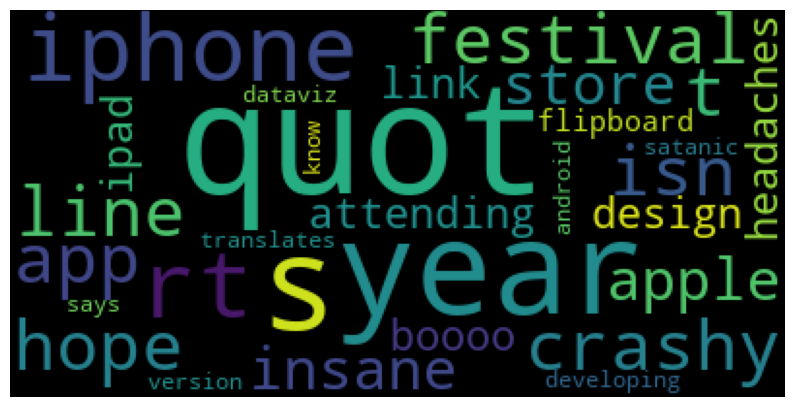

In [43]:
wordcloud_positive = create_wordclouds(df_sxsw,'Negative emotion')
word_cloud_pos = WordCloud(background_color='black',max_font_size=80).generate(" ".join(wordcloud_positive[:50]))
plt.figure(figsize=(10,6))
plt.imshow(word_cloud_pos)
plt.axis('off')
plt.show()

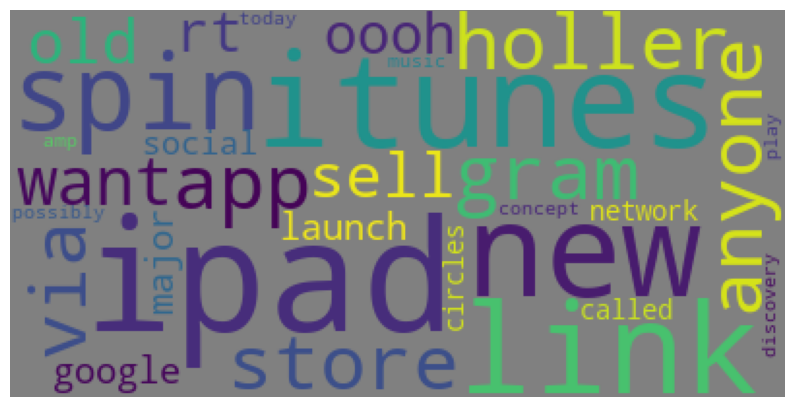

In [44]:
wordcloud_positive = create_wordclouds(df_sxsw,'Neutral emotion')
word_cloud_pos = WordCloud(background_color='gray',max_font_size=80).generate(" ".join(wordcloud_positive[:50]))
plt.figure(figsize=(10,6))
plt.imshow(word_cloud_pos)
plt.axis('off')
plt.show()

## Tweet Length Analysis

In [45]:
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                                                    clean_tweets  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from   
15                                                    haha awesomely rad ipad app by hollergram

In [46]:
df_sxsw['tweet_length'] = df_sxsw['clean_tweets'].apply(len)
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                                                    clean_tweets  \
3                         i hope this year s festival isn t as crashy as this year s iphone app    
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for     
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail   
14                                                                         great  ipad app from    
15                                                    haha awesomely rad ipad app by hollergram    

    tweet_length  
3             71  
8             78  
10            92  
14            21  
15            42

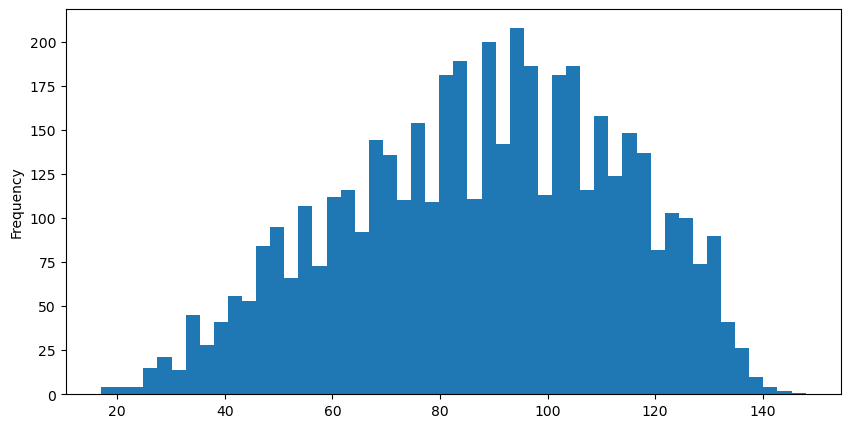

In [47]:
plt.figure(figsize=(10,5))
df_sxsw['tweet_length'].plot(bins=50,kind='hist');

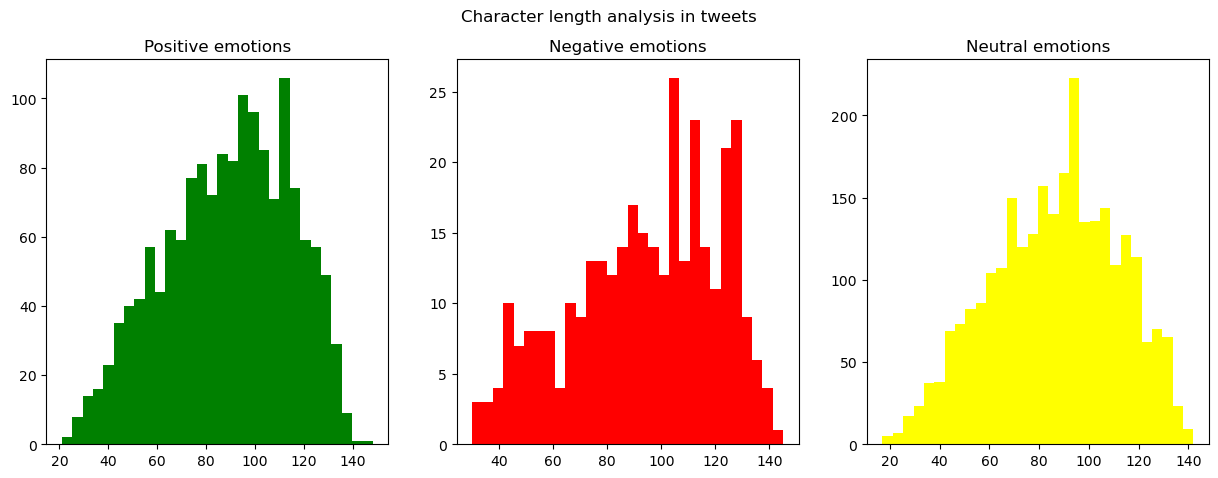

In [48]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

tweet_len_positive = df_sxsw[df_sxsw['emotion']=='Positive emotion']['tweet_length']
ax1.hist(tweet_len_positive,color='green',bins=30)
ax1.set_title('Positive emotions')

tweet_len_positive = df_sxsw[df_sxsw['emotion']=='Negative emotion']['tweet_length']
ax2.hist(tweet_len_positive,color='red',bins=30)
ax2.set_title('Negative emotions')

tweet_len_positive = df_sxsw[df_sxsw['emotion']=='Neutral emotion']['tweet_length']
ax3.hist(tweet_len_positive,color='yellow',bins=30)
ax3.set_title('Neutral emotions')

fig.suptitle('Character length analysis in tweets')
plt.show()

In [49]:
df_sxsw.drop(['tweet_length'],axis=1,inplace=True)

## N-Gram Analysis

In [50]:
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                                                    clean_tweets  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from   
15                                                    haha awesomely rad ipad app by hollergram

In [51]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

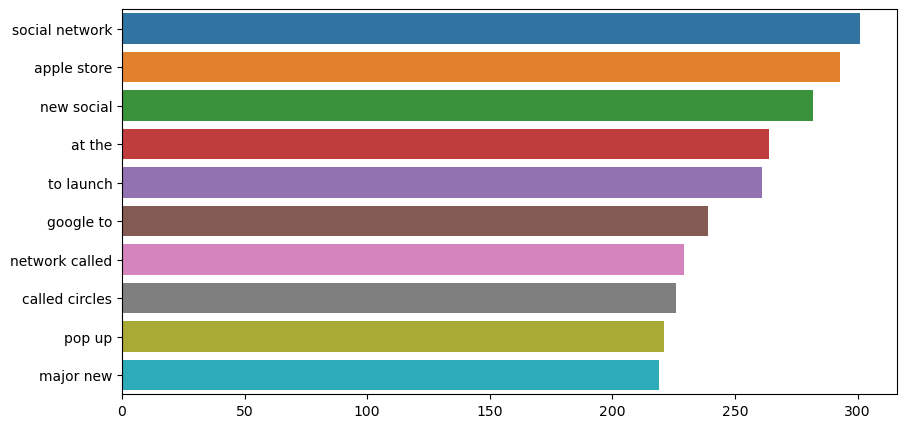

In [52]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_sxsw['clean_tweets'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x);

## Removing Punctions

In [53]:
def remove_punctuation(description):
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

In [61]:
df_sxsw['clean_tweets'] = df_sxsw['clean_tweets'].apply(remove_punctuation)
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                                                    clean_tweets  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from   
15                                                    haha awesomely rad ipad app by hollergram

## Removing Stopwords
* print(stopwords.fileids())

In [70]:
stop = stopwords.words('english')
stop[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [72]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [73]:
df_sxsw['clean_tweets'] = df_sxsw['clean_tweets'].apply(remove_stopwords)
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                      clean_tweets  
3                        hope year festival crashy year iphone app  
8       beautifully smart simple idea rt wrote hollergram ipad app  
10  excited meet show sprint galaxy still running android 2 1 fail  
14                                                  great ipad app  
15                          haha awesomely rad ipad app hollergram

## Removing Emojis

In [75]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [76]:
df_sxsw['clean_tweets'] = df_sxsw['clean_tweets'].apply(lambda x: remove_emoji(x))

## Count Vectorizer

In [77]:
vectorizer = CountVectorizer()
vectorizer.fit(df_sxsw['clean_tweets'])
vector = vectorizer.transform(df_sxsw['clean_tweets'])
print(vector.shape)

(4596, 6778)


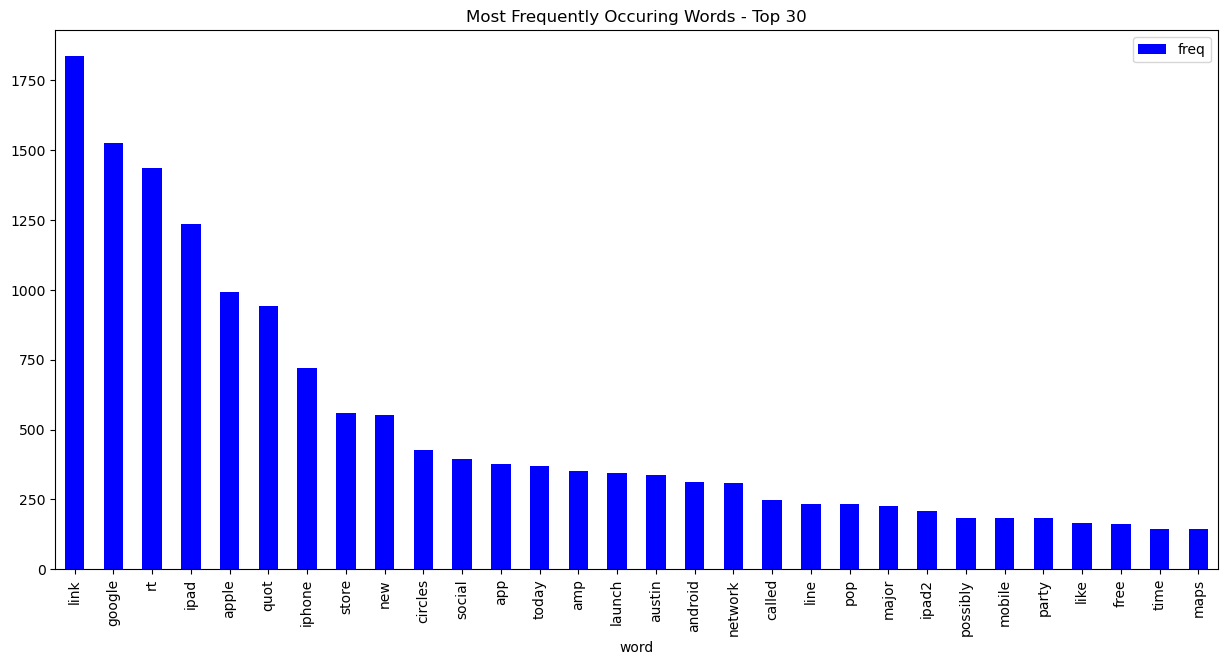

In [80]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_sxsw.clean_tweets)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30");

## TF-IDF

In [85]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()

In [90]:
df_sxsw.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
10  Positive emotion   
14  Positive emotion   
15  Positive emotion   

                                                      clean_tweets  
3                        hope year festival crashy year iphone app  
8       beautifully smart simple idea rt wrote hollergram ipad app  
10  excited meet show sprint galaxy still running android 2 1 fail  
14                                                  great ipad app  
15                          haha awesomely rad ipad app hollergram

In [91]:
X_tfidf[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

emotion
Neutral emotion     2725
Positive emotion    1536
Negative emotion     335
Name: count, dtype: int64


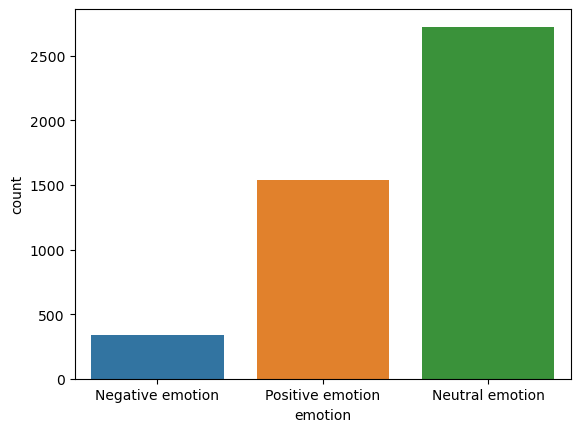

In [94]:
print(df_sxsw.emotion.value_counts())
sns.countplot(data=df_sxsw, x='emotion');

In [98]:
X = X_tfidf
y = df_sxsw['emotion']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=123)

In [100]:
sm = SMOTE()
X_train_over, y_train_over = sm.fit_resample(X_train,y_train)

In [102]:
type(y_train_over)

pandas.core.series.Series

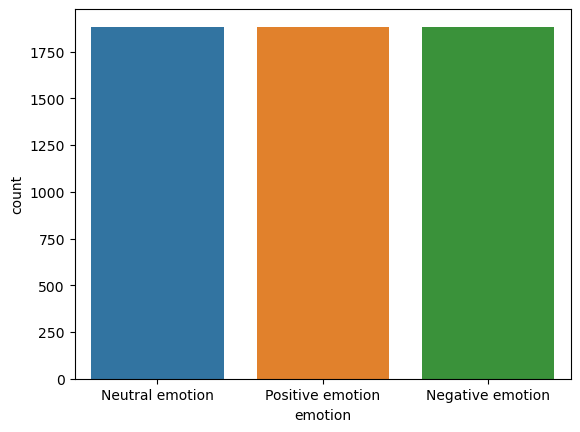

In [103]:
y_train_over_df = y_train_over.to_frame()
sns.countplot(data=y_train_over_df, x='emotion');

# Modeling

## Model 1 - Logistic Regression

In [127]:
lr = LogisticRegression()
lr.fit(X_train_over, y_train_over)
y_pred_lr = lr.predict(X_test)
log_df = pd.DataFrame(y_pred_lr, columns=['Pred_LogisticRegression'])

In [109]:
print("********** LOGISTIC REGRESSION CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) **********")
print('Accuracy score of training set', round(cross_val_score(lr, X_train_over, y_train_over, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of training set', round(cross_val_score(lr, X_train_over, y_train_over, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of training set', round(cross_val_score(lr, X_train_over, y_train_over, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of training set', round(cross_val_score(lr, X_train_over, y_train_over, cv=3, scoring= 'f1_weighted').mean(),2))
print("********** LOGISTIC REGRESSION CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) **********")
print('Accuracy score of testing set', round(cross_val_score(lr, X_test, y_test, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of testing set', round(cross_val_score(lr, X_test, y_test, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of testing set', round(cross_val_score(lr, X_test, y_test, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of testing set', round(cross_val_score(lr, X_test, y_test, cv=3, scoring= 'f1_weighted').mean(),2))

************************ LOGISTIC REGRESSION CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of training set 0.82
Precision score of training set 0.82
Recall score of training set 0.82
F1 score of training set 0.81
************************ LOGISTIC REGRESSION CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of testing set 0.64
Precision score of testing set 0.6
Recall score of testing set 0.64
F1 score of testing set 0.56


## Model 2 - Support Vector Machine Classifier

In [124]:
svc = LinearSVC()
svc.fit(X_train_over, y_train_over)
y_pred_svc = svc.predict(X_test)
svc_df = pd.DataFrame(y_pred_svc, columns=['Pred_SupportVectorMachine'])

In [111]:
print("************************ SVC CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of training set', round(cross_val_score(svc, X_train_over, y_train_over, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of training set', round(cross_val_score(svc, X_train_over, y_train_over, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of training set', round(cross_val_score(svc, X_train_over, y_train_over, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of training set', round(cross_val_score(svc, X_train_over, y_train_over, cv=3, scoring= 'f1_weighted').mean(),2))
print("************************ SVC CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of testing set', round(cross_val_score(svc, X_test, y_test, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of testing set', round(cross_val_score(svc, X_test, y_test, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of testing set', round(cross_val_score(svc, X_test, y_test, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of testing set', round(cross_val_score(svc, X_test, y_test, cv=3, scoring= 'f1_weighted').mean(),2))

************************ SVC CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of training set 0.84
Precision score of training set 0.84
Recall score of training set 0.84
F1 score of training set 0.84
************************ SVC CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of testing set 0.64
Precision score of testing set 0.62
Recall score of testing set 0.64
F1 score of testing set 0.6


## Model 3 - Complement Naive Bayes Classifier

In [126]:
nbc = ComplementNB()
nbc.fit(X_train_over, y_train_over)
y_pred_nbc = nbc.predict(X_test)
nb_df = pd.DataFrame(y_pred_nbc, columns=['Pred_ComplementNB'])

In [113]:
print("************************ ComplementNB CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of training set', round(cross_val_score(nbc, X_train_over, y_train_over, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of training set', round(cross_val_score(nbc, X_train_over, y_train_over, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of training set', round(cross_val_score(nbc, X_train_over, y_train_over, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of training set', round(cross_val_score(nbc, X_train_over, y_train_over, cv=3, scoring= 'f1_weighted').mean(),2))
print("************************ ComplementNB CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of testing set', round(cross_val_score(nbc, X_test, y_test, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of testing set', round(cross_val_score(nbc, X_test, y_test, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of testing set', round(cross_val_score(nbc, X_test, y_test, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of testing set', round(cross_val_score(nbc, X_test, y_test, cv=3, scoring= 'f1_weighted').mean(),2))

************************ ComplementNB CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of training set 0.77
Precision score of training set 0.78
Recall score of training set 0.77
F1 score of training set 0.76
************************ ComplementNB CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of testing set 0.6
Precision score of testing set 0.57
Recall score of testing set 0.6
F1 score of testing set 0.57


## Model 4 - Random Forest Classifier

In [128]:
rf = RandomForestClassifier()
rf.fit(X_train_over, y_train_over)
y_pred_rf = rf.predict(X_test)
rf_df = pd.DataFrame(y_pred_rf, columns=['Pred_RandomForestClassifier'])

In [115]:
print("************************ RF CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of training set', round(cross_val_score(rf, X_train_over, y_train_over, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of training set', round(cross_val_score(rf, X_train_over, y_train_over, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of training set', round(cross_val_score(rf, X_train_over, y_train_over, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of training set', round(cross_val_score(rf, X_train_over, y_train_over, cv=3, scoring= 'f1_weighted').mean(),2))
print("************************ RF CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************")
print('Accuracy score of testing set', round(cross_val_score(rf, X_test, y_test, cv=3, scoring= 'accuracy').mean(),2))
print('Precision score of testing set', round(cross_val_score(rf, X_test, y_test, cv=3, scoring= 'precision_weighted').mean(),2))
print('Recall score of testing set', round(cross_val_score(rf, X_test, y_test, cv=3, scoring= 'recall_weighted').mean(),2))
print('F1 score of testing set', round(cross_val_score(rf, X_test, y_test, cv=3, scoring= 'f1_weighted').mean(),2))

************************ RF CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of training set 0.83
Precision score of training set 0.84
Recall score of training set 0.83
F1 score of training set 0.83
************************ RF CLASSIFIER TRAINING DATASET MODEL RESULTS (CROSS-VALIDATED) ************************
Accuracy score of testing set 0.63
Precision score of testing set 0.64
Recall score of testing set 0.63
F1 score of testing set 0.56


## Model Comparisons

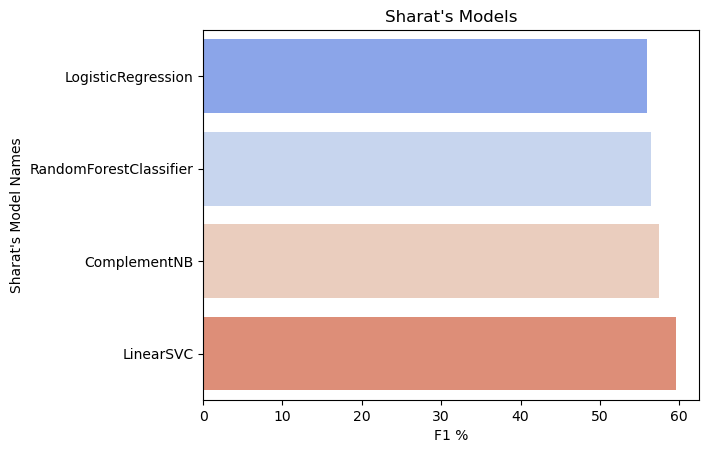

In [116]:
models = [lr, rf, nbc, svc]

result_f1 = []
results_f1 = pd.DataFrame(columns=["Models", "F1"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    f1score = cross_val_score(model, X_test, y_test, cv=3, scoring="f1_weighted", n_jobs=-1).mean()
    result_f1 = pd.DataFrame([[names, f1score*100]], columns=["Models", "F1"])
    results_f1 = results_f1._append(result_f1)
    
sns.barplot(x='F1', y='Models', data= results_f1, palette="coolwarm")
plt.xlabel('F1 %')
plt.ylabel("Sharat's Model Names")
plt.title("Sharat's Models", loc="center")
plt.show();

In [118]:
results_f1.sort_values(by='F1',ascending=False)

Models         F1
0               LinearSVC  59.537423
0            ComplementNB  57.410838
0  RandomForestClassifier  56.463769
0      LogisticRegression  55.991140

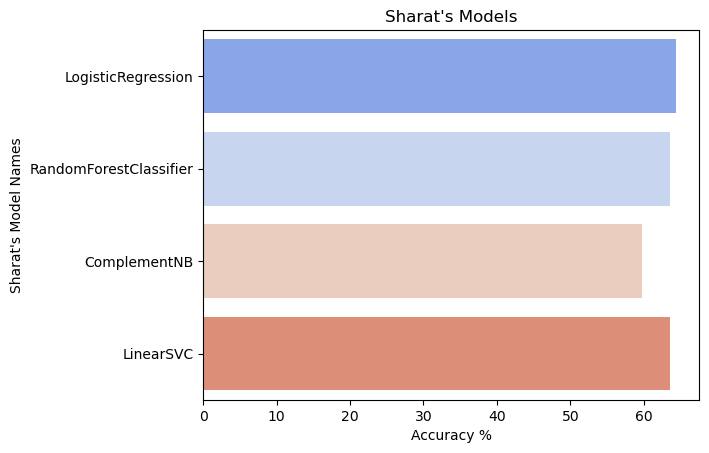

In [119]:
models = [lr, rf, nbc, svc]

result_accuracy = []
results_accuracy = pd.DataFrame(columns=["Models", "Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accuracy = cross_val_score(model, X_test, y_test, cv=3, scoring="accuracy", n_jobs=-1).mean()
    result_accuracy = pd.DataFrame([[names, accuracy*100]], columns=["Models", "Accuracy"])
    results_accuracy = results_accuracy._append(result_accuracy) 

sns.barplot(x='Accuracy', y='Models', data= results_accuracy, palette="coolwarm")
plt.xlabel('Accuracy %')
plt.ylabel("Sharat's Model Names")
plt.title("Sharat's Models", loc="center")
plt.show();

In [120]:
results_accuracy.sort_values(by='Accuracy',ascending=False)

Models   Accuracy
0      LogisticRegression  64.322882
0               LinearSVC  63.525623
0  RandomForestClassifier  63.525307
0            ComplementNB  59.754349

## Hyperparameter Optimization
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

## Real Tweet Classes versus Models' Predictions

In [138]:
final_merged_df = pd.concat([df_sxsw[['clean_tweets','emotion']],log_df, nb_df, svc_df, rf_df],axis=1).dropna()
final_merged_df.head(15)

clean_tweets  \
3                                                       hope year festival crashy year iphone app   
8                                      beautifully smart simple idea rt wrote hollergram ipad app   
10                                 excited meet show sprint galaxy still running android 2 1 fail   
14                                                                                 great ipad app   
15                                                         haha awesomely rad ipad app hollergram   
16                                                          holler gram ipad itunes app store via   
22                                                     okay really yay new android app 11 kthxbai   
26                                                  rt haha awesomely rad ipad app hollergram via   
27                                      someone started austin group google groups pre great idea   
29                                                     right 3 app android sweeeeet nice job team   
30                                              smart hollergram ipad app may leave vuvuzela home   
33                                                                      anyone want sell old ipad   
35              oooh rt google launch major new social network called circles possibly today link   
36  best rt ha first line ipad2 quot pop quot apple store event planner eventprofs pcma engage365   
37                            spin play new concept music discovery ipad amp spin com link itunes   

             emotion Pred_LogisticRegression Pred_ComplementNB  \
3   Negative emotion         Neutral emotion   Neutral emotion   
8   Positive emotion         Neutral emotion   Neutral emotion   
10  Positive emotion         Neutral emotion  Positive emotion   
14  Positive emotion         Neutral emotion   Neutral emotion   
15  Positive emotion        Negative emotion  Negative emotion   
16   Neutral emotion         Neutral emotion   Neutral emotion   
22  Positive emotion        Positive emotion  Positive emotion   
26  Positive emotion        Positive emotion  Positive emotion   
27  Positive emotion        Negative emotion  Negative emotion   
29  Positive emotion         Neutral emotion   Neutral emotion   
30  Positive emotion         Neutral emotion   Neutral emotion   
33   Neutral emotion        Positive emotion  Positive emotion   
35   Neutral emotion        Negative emotion  Negative emotion   
36  Positive emotion        Positive emotion  Positive emotion   
37   Neutral emotion         Neutral emotion   Neutral emotion   

   Pred_SupportVectorMachine Pred_RandomForestClassifier  
3            Neutral emotion             Neutral emotion  
8            Neutral emotion             Neutral emotion  
10           Neutral emotion             Neutral emotion  
14           Neutral emotion             Neutral emotion  
15          Negative emotion             Neutral emotion  
16           Neutral emotion             Neutral emotion  
22          Positive emotion            Positive emotion  
26          Positive emotion            Positive emotion  
27           Neutral emotion             Neutral emotion  
29           Neutral emotion             Neutral emotion  
30           Neutral emotion             Neutral emotion  
33          Positive emotion            Positive emotion  
35          Positive emotion            Positive emotion  
36          Positive emotion             Neutral emotion  
37           Neutral emotion             Neutral emotion